<a id="top"></a>

[![](./media/Db2_header_3.png)](https://www.ibm.com/demos/collection/db2-database/)
<a id="top">

In [5]:
%run refresh.ipynb

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# External Tables on Db2 for Openshift
Db2 11.5 introduces support for External tables. External tables are objects that reside on a local or remote file system that Db2 can create or read as if they were standard SQL tables. The advantage of using external tables for Extraction-Transformation-Loading (ETL) processes is that they can be carried out using plain SQL. Because an SQL-based ETL process can be initiated from any SQL client, it eliminates the need for special ETL tools.

Use an external table to: 
* Load data from an external file into a table in the database
* Unload data from the database into an external file
* Store data outside the database while retaining the ability to query that data

External Table Usage:
* Use a FROM clause in a SELECT SQL statement as you would for any other table
* Specify the external table as the target table in one of the following SQL statements:
  - `INSERT SQL`
  - `SELECT INTO SQL`
  - `CREATE EXTERNAL TABLE AS SELECT SQL`

* You can perform operations such as casts, joins, and dropping columns to manipulate data during loading


## The Difference working With OpenShift and External Tables

With Opernshift and container deployments there is no going in through the front door, so to speak, to put files on a server. Instead they need to be placed in the Persistent Volume your db2 Openshift deployment has a claim on and we prescribe specific directory that is available to db2 Data partitions across all nodes. they is going to be the "scratch" directory within the persistent volume we created earlier.

from a Db2 perspective, this means we will set our external tables path to "/mnt/bluemeta0/scratch"

### Load Db2 Extensions and Connect to the Database
The `connection` notebook contains the `CONNECT` statement which allows access to the `SAMPLE` database. If you need to modify the connection information, edit the `connection.ipynb` notebook.

In [4]:
%run db2.ipynb

Db2 Extensions Loaded.


In [4]:
%sql connect to bludb user db2inst1 using db2inst1 host 192.168.154.132 port 32605

Connection successful.


## A Video Introduction to External Tables
This video will review all of the details surrounding the External Table syntax. 

In [6]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/embed/RMMExarvBVk">

## Detailed Presentation on External Tables
The following presentation will take you through some of the features that are available with External Tables. You can also use the links below to view the presentation in a separate window. Below this presentation you will see examples of External Tables in action.

In [7]:
%%html
<iframe width="800" height="500" src="http://www.slideshare.net/slideshow/embed_code/key/ynOvNEfYGrQZ7q">

[IBM Db2 11.5 External Tables](https://www.slideshare.net/PhilDowney1/ibm-db2-115-external-tables-196331418) by
[Phil Downey](https://www.slideshare.net/PhilDowney1)

Retrieving the name of the notebook user for future use.

### External Table Path
In order for Db2 to access external tables, it must be given the relative access path for these objects. The next cell will get the current path that we are running in. This path will then be used to update the Database `EXTBL_LOCATION` field so that the reads and writes to external tables will run.

In [73]:
import os
notebook_directory = os.path.abspath('.')
print('The current notebook directory is ' + notebook_directory)

The current notebook directory is /home/db2pot/notebooks


To allow simultaneous users to access the external table directory, we are going to use `DB2INST1` home directory as the location of all of the files. 

In [58]:
db2inst1_directory = '/mnt/blumeta0/scratch'
Persistent_volume_directory = '/home/db2pot/db2vol1/scratch'

We create a string that will update the database configuration so that the `DB2INST1` directory will be used as the directory for all files.

In [19]:
admin_cmd = 'UPDATE DB CONFIG FOR BLUDB USING EXTBL_LOCATION "' + db2inst1_directory + '" IMMEDIATE'

The following SQL will use the Db2 `ADMIN_CMD` to update the database setting to allow for reading and writing of external files to this directory.

In [20]:
%sql CALL ADMIN_CMD({admin_cmd})

### External Table Files
The three files that are used for the external table examples will be copied from the notebook directory to the `DB2INST1` home directory. If copies of the files already exist, they will not be replaced. If you do want to replace the existing files, remove the `-u` flag from the command.

In [78]:
cmd = "cp -uf {0}/*.csv {1}".format(notebook_directory, Persistent_volume_directory)
print(cmd)
!{cmd}

cp -uf /home/db2pot/notebooks/*.csv /home/db2pot/db2vol1/scratch


### Stocks Tables
The following examples will use two files to demonstrate the use of External tables. The two files are:
- Stock Data - Information for all opening and closing values for the DJIA average in 2018
- Stock Labels - Full name of the stock indexes
The files are located within this notebook directory so when refering to these files in Db2 we must supply an absolute address, not a relative one to Db2.

### Absolute Path
We need to use the absolute path of a file for use with Db2, so we create the full paths for the two files.

In [65]:
import os
djia_2018    = "{0}/{1}".format(db2inst1_directory,"djia-2018.csv")
djia_symbols = "{0}/{1}".format(db2inst1_directory,"djia-symbols.csv")
print(djia_2018)
print(djia_symbols)

/mnt/blumeta0/scratch/djia-2018.csv
/mnt/blumeta0/scratch/djia-symbols.csv


The first step is to verify the files and display the first 5 lines of each file.

### Using SELECT (Transient) statements against External Tables
The following SQL will read the data from the `SYMBOLS` table and display it in a grid.

In [62]:
%%time
sql = """
SELECT * FROM EXTERNAL :djia_symbols (
    SYMBOL VARCHAR(10),
    NAME   VARCHAR(255)
    )
    USING ( DELIMITER ',' STRING_DELIMITER DOUBLE SKIP_ROWS 1 NOLOG TRUE )
"""
%sql {sql}

CPU times: user 3.08 ms, sys: 1.61 ms, total: 4.7 ms
Wall time: 102 ms


###### This next SQL statement will retrieve all of the data from the 2018 stock transactions.

In [25]:
%%sql
SELECT * FROM EXTERNAL :djia_2018 (
    SYMBOL    VARCHAR(4),
    TX_DATE   DATE,
    HIGH_VAL  DEC(9,2),
    LOW_VAL   DEC(9,2),
    OPEN_VAL  DEC(9,2),
    CLOSE_VAL DEC(9,2),
    VOLUME    INT
    )
    USING ( DELIMITER ',' STRING_DELIMITER DOUBLE SKIP_ROWS 1 NOLOG TRUE )

,SYMBOL,TX_DATE,HIGH_VAL,LOW_VAL,OPEN_VAL,CLOSE_VAL,VOLUME
0,AAPL,2017-12-18,177.20,174.86,174.88,176.42,29421100
1,AAPL,2017-12-19,175.39,174.09,175.03,174.54,27436400
2,AAPL,2017-12-20,175.42,173.25,174.87,174.35,23475600
3,AAPL,2017-12-21,176.02,174.10,174.17,175.01,20949900
4,AAPL,2017-12-22,175.42,174.50,174.68,175.01,16114600
...,...,...,...,...,...,...,...
7495,XOM,2018-12-10,77.86,74.80,77.86,76.54,17946200
7496,XOM,2018-12-11,77.80,75.68,77.70,76.68,15742400
7497,XOM,2018-12-12,78.20,76.02,78.04,76.02,14559800
7498,XOM,2018-12-13,77.22,75.95,76.03,76.98,13749700


### Cataloging External Tables
The previous examples used a transient form of external table. The external table definition only existed during the execution of the SQL statement. Rather than define the external table every time, you have the option of cataloging the external table. When the external table is cataloged, you refer to it in the same way as a standard SQL table. The underlying file is checked at execution time, so it is possible that this file changes from day to day. Only when the SQL is executed is the existence of the file checked.

In [50]:
%%sql 
DROP TABLE IF EXISTS DJIA_2018;
DROP TABLE IF EXISTS DJIA_SYMBOLS;

Command completed.


The `CREATE EXTERNAL TABLE` uses the same syntax as the transient example shown earlier. The only difference is that we are creating an actual entry in the Db2 catalog that will refer to this external table.

In [27]:
%%sql
CREATE EXTERNAL TABLE DJIA_2018  
    (
    SYMBOL    VARCHAR(4),
    TX_DATE   DATE,
    HIGH_VAL  DEC(9,2),
    LOW_VAL   DEC(9,2),
    OPEN_VAL  DEC(9,2),
    CLOSE_VAL DEC(9,2),
    VOLUME    INT
    )
    USING ( DELIMITER ',' STRING_DELIMITER DOUBLE SKIP_ROWS 1 FILE_NAME :djia_2018 NOLOG TRUE );

CREATE EXTERNAL TABLE DJIA_SYMBOLS  
    (
    SYMBOL VARCHAR(4),
    NAME   VARCHAR(255)
    )
    USING ( DELIMITER ',' STRING_DELIMITER DOUBLE SKIP_ROWS 1 FILE_NAME :djia_symbols NOLOG TRUE ) ;

Command completed.


The external tables can now be referenced in a SQL statement in the same way as any other SQL table. External tables cannot be indexed or be part of summary tables. 

The next SQL statement retrieves only the transactions that exceeded 180 in value and belonged to AAPL.

In [28]:
%sql -grid select * from djia_2018 where symbol='AAPL' and close_val > 180

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

Since these external tables are cataloged and look like any other SQL table, we can include joins and other calculations on the columns.

In [29]:
%%sql -grid
SELECT S.NAME, MAX(HIGH_VAL) AS HIGH, MIN(LOW_VAL) AS LOW, MAX(VOLUME) AS MAX_VOLUME, MIN(VOLUME) AS MIN_VOLUME
  FROM DJIA_SYMBOLS S, DJIA_2018 T
WHERE
  S.SYMBOL = T.SYMBOL
GROUP BY S.NAME

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

<a id="Slides"></a>

## Additional External Table Scenarios
This section will explore some additional ways of using External tables. The `product_txs.csv` file contains approximately 100000 transactions that will be queried in this section. 

The first step is to get the absolute file location of the product file.

In [30]:
import os
product_txs    = "{0}/{1}".format(db2inst1_directory,"product_txs.csv")

We check to make sure that we have access to the external file with the following SQL statement. Note that we can restrict the number of records being returned either with the `USING MAXROWS` clause of the external table statement, or by using the SQL `FETCH FIRST` syntax.

In [31]:
%%sql -grid
SELECT * FROM EXTERNAL :product_txs
  ( 
  RECEIPT_ID BIGINT, 
  TX_DATE    CHAR(10),
  TX_NO      INT,
  PRODUCT_ID INT,
  PRODUCT    VARCHAR(100), 
  QUANTITY   INT ,
  ITEM_COST  DEC(15,2)
  ) 
  USING ( DELIMITER ',' SKIPROWS 1 NOLOG TRUE ) 
FETCH FIRST 100 ROWS ONLY

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

To make our life easier, we will create a catalog entry for this external table.

In [56]:
%%sql  
DROP TABLE  IF EXISTS PRODUCT_TXS;
CREATE EXTERNAL TABLE PRODUCT_TXS
  ( 
  RECEIPT_ID BIGINT, 
  TX_DATE    CHAR(10),
  TX_NO      INT,
  PRODUCT_ID INT,
  PRODUCT    VARCHAR(100), 
  QUANTITY   INT ,
  ITEM_COST  DEC(15,2)
  ) 
  USING ( DATAOBJECT :product_txs DELIMITER ',' SKIPROWS 1 NOLOG TRUE )  

Command completed.


We should now be able to retrieve data from this table using standard SQL syntax.

In [33]:
%sql SELECT * FROM PRODUCT_TXS FETCH FIRST 10 ROWS ONLY

,RECEIPT_ID,TX_DATE,TX_NO,PRODUCT_ID,PRODUCT,QUANTITY,ITEM_COST
0,10108,2018-10-12,301727,1156,Garden Sprinkler,1,252.82
1,10084,2018-08-17,219572,1180,Rake,1,211.04
2,10052,2017-05-26,151729,1625,Rake,1,290.50
3,10031,2017-05-07,158870,1040,Rake,1,269.79
4,10017,2018-06-20,216252,1883,Miniature Scythe,1,110.04
5,9977,2018-08-21,255751,1336,Precision Edger Turbo,1,214.28
6,9954,2019-04-16,221938,1609,Rake,1,293.66
7,9926,2017-08-25,203057,1640,Rake,1,261.52
8,9922,2017-08-26,263501,1367,Rake,1,180.08
9,9906,2017-06-19,300412,1045,Rake,1,189.48


For reference, let's see how many records are found in the product table.

In [34]:
result = %sql -r -nq SELECT COUNT(*) FROM PRODUCT_TXS
product_count = result[1][0]
print(product_count)

92773


## Merging Data From an External Table into a Database Table
The following SQL will merge data from the external table into an existing table. One shortcut that you can use with external tables is through the use of the `LIKE` clause. If a table already exists that has the same columns as the external table, you can use its definition rather than explicitly typing them out.

The real table that we are going to use is called `ASSOC_TRANS` and will be used as a template for our external table.

In [55]:
%%sql 
DROP TABLE IF EXISTS ASSOC_TRANS;
CREATE TABLE ASSOC_TRANS
  ( 
  RECEIPT_ID BIGINT, 
  TX_DATE    CHAR(10),
  TX_NO      INT,
  PRODUCT_ID INT,
  PRODUCT    VARCHAR(100), 
  QUANTITY   INT ,
  ITEM_COST  DEC(15,2)
  ) 
NOT LOGGED INITIALLY

Command completed.


The transactions in the external table that are not `Rake` are inserted into the `ASSOC_TRANS` table.

In [36]:
%%sql
MERGE INTO ASSOC_TRANS T_OLD 
USING (
      SELECT * FROM EXTERNAL :product_txs
         LIKE ASSOC_TRANS USING ( DELIMITER ',' SKIPROWS 1 NOLOG TRUE )
      WHERE PRODUCT <> 'Rake'
      ) AS T_NEW 
ON (T_OLD.RECEIPT_ID = T_NEW.RECEIPT_ID and T_OLD.TX_NO = T_NEW.TX_NO) 
WHEN NOT MATCHED THEN 
  INSERT (RECEIPT_ID, TX_DATE, TX_NO, PRODUCT_ID, PRODUCT, QUANTITY, ITEM_COST) 
    VALUES (T_NEW.RECEIPT_ID, T_NEW.TX_DATE, T_NEW.TX_NO, T_NEW.PRODUCT_ID, T_NEW.PRODUCT,
            T_NEW.QUANTITY, T_NEW.ITEM_COST)

Command completed.


At this point the table should contain all records except the ones that were for `Rake`. We do a quick count to see how many records there are.

In [37]:
%sql SELECT COUNT(*) FROM ASSOC_TRANS

,1
0,72908


We can also ceate a single view of the rows already loaded combined with those for Rake that are not.

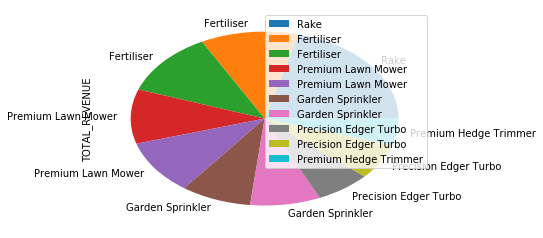

In [38]:
%%sql -pp
SELECT  PRODUCT,SUM(ITEM_COST) TOTAL_REVENUE FROM ASSOC_TRANS 
GROUP BY PRODUCT
  UNION ALL
SELECT  PRODUCT,SUM(ITEM_COST) TOTAL_REVENUE FROM PRODUCT_TXS 
GROUP BY PRODUCT
ORDER BY TOTAL_REVENUE DESC FETCH FIRST 10 ROWS ONLY ;

The next SQL statement will merge all of the records from the external table into this regular SQL table. If the record already exists, it will be ignored, otherwise it will be inserted into the table.

In [39]:
%%sql 
MERGE INTO ASSOC_TRANS T_OLD 
USING (
      SELECT * FROM EXTERNAL :product_txs 
         LIKE ASSOC_TRANS USING ( DELIMITER ',' SKIPROWS 1 NOLOG TRUE )
      ) AS T_NEW 
ON (T_OLD.RECEIPT_ID = T_NEW.RECEIPT_ID and T_OLD.TX_NO = T_NEW.TX_NO) 
WHEN NOT MATCHED THEN 
  INSERT (RECEIPT_ID, TX_DATE, TX_NO, PRODUCT_ID, PRODUCT, QUANTITY, ITEM_COST) 
    VALUES (T_NEW.RECEIPT_ID, T_NEW.TX_DATE, T_NEW.TX_NO, T_NEW.PRODUCT_ID, T_NEW.PRODUCT,
            T_NEW.QUANTITY, T_NEW.ITEM_COST)
ELSE IGNORE

Command completed.


Now let's find out how many records there are in the `ASSOC_TRANS` table and compare that to the original size of the external product table.

In [40]:
%sql SELECT COUNT(*) FROM ASSOC_TRANS;

,1
0,92773


The product count should be the same.

In [41]:
print(product_count)

92773


## Creating an External Table
You can create external tables by using the `CREATE EXTERNAL TABLE ... AS SELECT...` syntax. The SELECT can contain any arbitrary SQL so the statements can become very complex. You must ensure that Db2 has write access to the directory where the file will be written out to.

First we must define the name of the external table that we want to write to. In order to do that, we generate a path that includes the current directory and append the schema (owner) and the name of the file to it.

In [61]:
dumpfile = "{0}/dump.csv".format(db2inst1_directory)
print(dumpfile)

/mnt/blumeta0/scratch/dump.csv


The next SQL statement will output the contents of the `ASSOC_TRANS` table to the external file. You can limit the amount of data that gets written with the `USING` clause, or you can use SQL options to limit it.

In [45]:
%%sql 
CREATE EXTERNAL TABLE :dumpfile 
  USING ( DELIMITER '|' NOLOG TRUE ) 
  AS SELECT * FROM ASSOC_TRANS FETCH FIRST 100 ROWS ONLY

Command completed.


You must make sure you have the proper permissions to read the file if using anything outside of the Db2 environment. The file that was generated was created under the `CONNECT` userid for this notebook. If you used `DB2INST1` then only that user can access the file. The following code will fail if you didn't have the proper permissions to read the file.

In [59]:
try:
    file  = open(Persistent_volume_directory+'/dump.csv')
    file_contents = file.read(100)
    print(file_contents)
    file.close()
except Exception as e:
    print("Open failed")
    print(e)

9774|2017-03-30|271184|1087|Leaf Blower|1|156.73
8289|2017-03-24|166488|1336|Precision Edger Turbo|1


However, as a SQL user, you can read it!

In [60]:
%%sql
SELECT * FROM EXTERNAL :dumpfile LIKE ASSOC_TRANS USING ( DELIMITER '|' SKIPROWS 1 NOLOG TRUE ) 

,RECEIPT_ID,TX_DATE,TX_NO,PRODUCT_ID,PRODUCT,QUANTITY,ITEM_COST
0,8289,2017-03-24,166488,1336,Precision Edger Turbo,1,214.28
1,8027,2018-08-04,171721,1075,Leaf Blower,1,227.60
2,7783,2017-07-15,252128,1003,Chubby Grinder,1,267.30
3,7018,2017-09-13,136168,1018,Round Shovel,1,220.57
4,7011,2017-11-11,215199,1204,Premium Lawn Mower,1,204.77
...,...,...,...,...,...,...,...
94,804651,2017-03-08,960513,1011,Premium Lawn Mower,1,241.71
95,804092,2018-08-26,991300,1441,Garden Sprinkler,1,157.96
96,803168,2019-05-03,915121,1995,Green Table Saw,1,195.17
97,803142,2018-10-20,1055846,1337,Aerator,1,200.09


[Back to Top](#top)
<a id='function'></a>

[![](./media/db2_dte_footer.png)](https://www.ibm.com/demos/collection/db2-database/)
<a id="top">

#### Credits: IBM 2020, Phil Downey [phil.downey1@ibm.com], George Baklarz [baklarz@ca.ibm.com]